Factores asociados a enfermedades cardiovasculares
Autor: Jose Luis Belloso, | Fecha: 17/09/2025

Premisas

• cuales son los factores de riesgo asociados a enfermedades cardiacas.
• cual es top 15 de esos factores de riesgo.
• cual es la corrección entre esos factores de riesgo.
• cual es la primera causa de factor de riesgo.

Descripción del conjunto de datos y sus variables
Registros: 319,795 | Variables: 18
Variable objetivo: HeartDisease

Conclusiones

• El análisis confirmó que la acumulación de estos factores aumenta la probabilidad de padecer afecciones cardiacas. Con apoyo de especialistas y un simposio nacional, lograron generar datos rigurosos y validados. 
• Dentro del top 10, el BMI, como primera causa de padecer afecciones cardiacas.
BMI = Body Mass Index o Índice de Masa Corporal (IMC).
Es una medida estándar para evaluar si una persona tiene un peso adecuado en relación con su estatura.
Valores bajos (< 12.95): podrían corresponder a errores de captura, personas con desnutrición severa o casos clínicos extremos.
Valores altos (> 42.51): reflejan obesidad severa o mórbida; algunos también podrían ser errores en la base (por ejemplo, estaturas mal ingresadas).
El alto número de outliers en la población con IMC elevado, lo cual sí es un factor de riesgo importante para enfermedades cardiovasculares.



In [1]:

import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

plt.rcParams['figure.figsize'] = (8,5)

DATA_PATH = Path('/mnt/data/heart_2020_cleaned.csv')
SAVE_DIR = Path('/mnt/data/outputs')
SAVE_DIR.mkdir(exist_ok=True, parents=True)

assert DATA_PATH.exists(), f'No se encontró el archivo: {DATA_PATH}'
print('Archivo de datos:', DATA_PATH)


Archivo de datos: /mnt/data/heart_2020_cleaned.csv


In [2]:

df = pd.read_csv(DATA_PATH)
print(df.shape)
df.head()


(319795, 18)


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [3]:

display(df.describe(include='all').T)
print('\nTipos de datos:')
print(df.dtypes.value_counts())
print('\nValores faltantes (top 20):')
missing = df.isna().mean().sort_values(ascending=False)
display(missing[missing>0].head(20))


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
HeartDisease,319795,2,No,292422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BMI,319795.0,NaN,NaN,NaN,28.325399,6.3561,12.02,24.03,27.34,31.42,94.85
Smoking,319795,2,No,187887,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AlcoholDrinking,319795,2,No,298018,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stroke,319795,2,No,307726,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PhysicalHealth,319795.0,NaN,NaN,NaN,3.37171,7.95085,0.0,0.0,0.0,2.0,30.0
MentalHealth,319795.0,NaN,NaN,NaN,3.898366,7.955235,0.0,0.0,0.0,3.0,30.0
DiffWalking,319795,2,No,275385,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,319795,2,Female,167805,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AgeCategory,319795,13,65-69,34151,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Tipos de datos:
object     14
float64     4
dtype: int64

Valores faltantes (top 20):


Series([], dtype: float64)

In [4]:

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category','bool']).columns.tolist()

target_candidates = ['HeartDisease','heart_disease','target','disease','outcome','label','y']
target = None
for c in df.columns:
    if c in target_candidates or c.lower() in target_candidates:
        target = c; break
if target is None:
    for c in df.columns:
        if df[c].nunique(dropna=True)==2: target=c; break

print('Numéricas:', len(num_cols))
print('Categóricas:', len(cat_cols))
print('Variable objetivo detectada:', target)


Numéricas: 4
Categóricas: 14
Variable objetivo detectada: HeartDisease


## Univariado — Numéricas

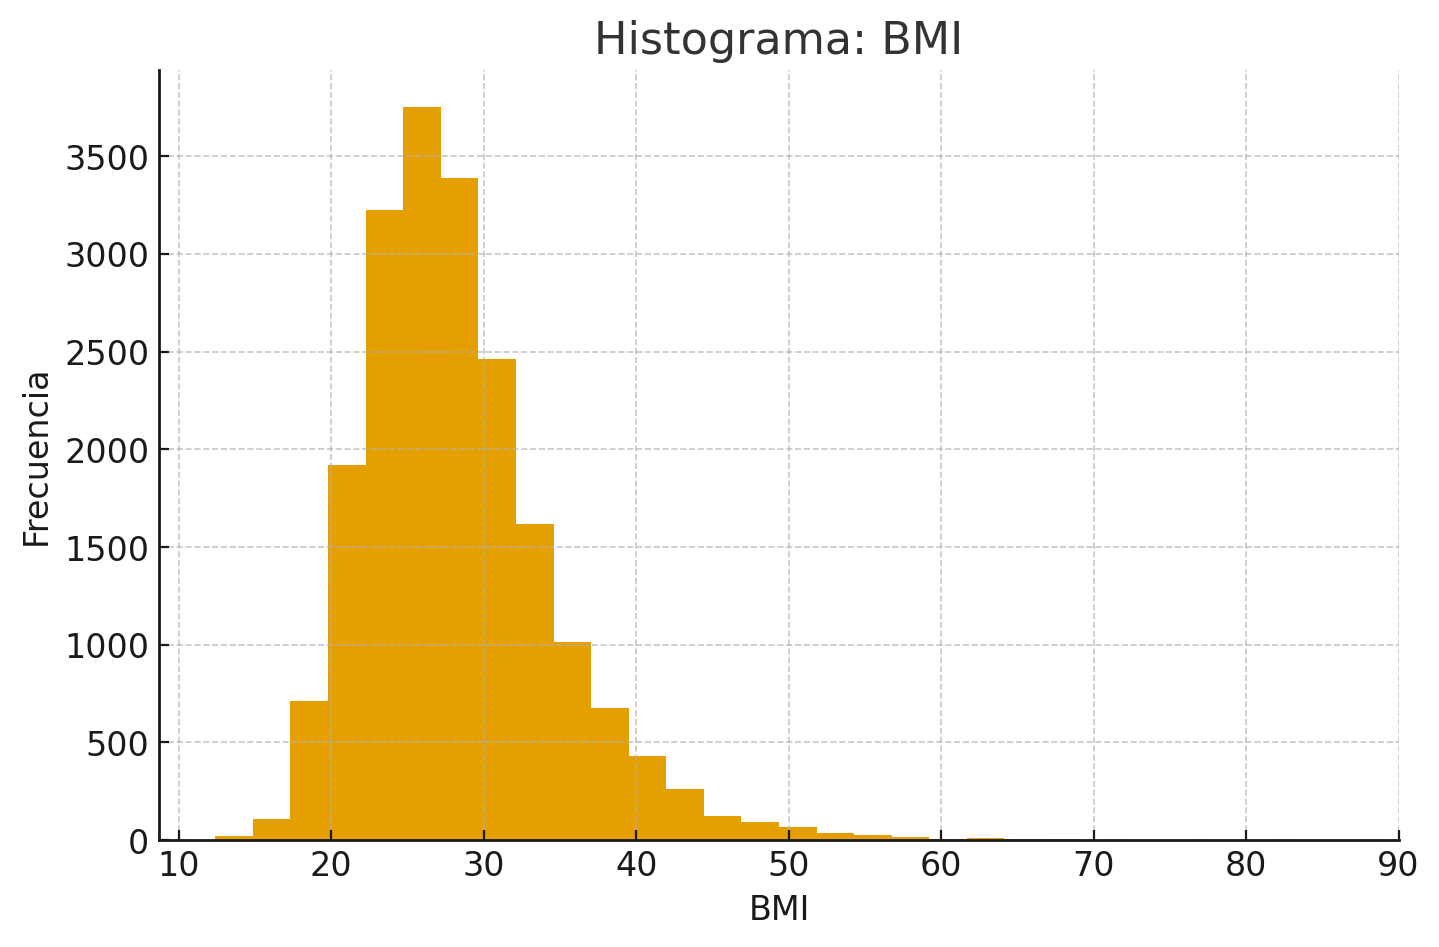

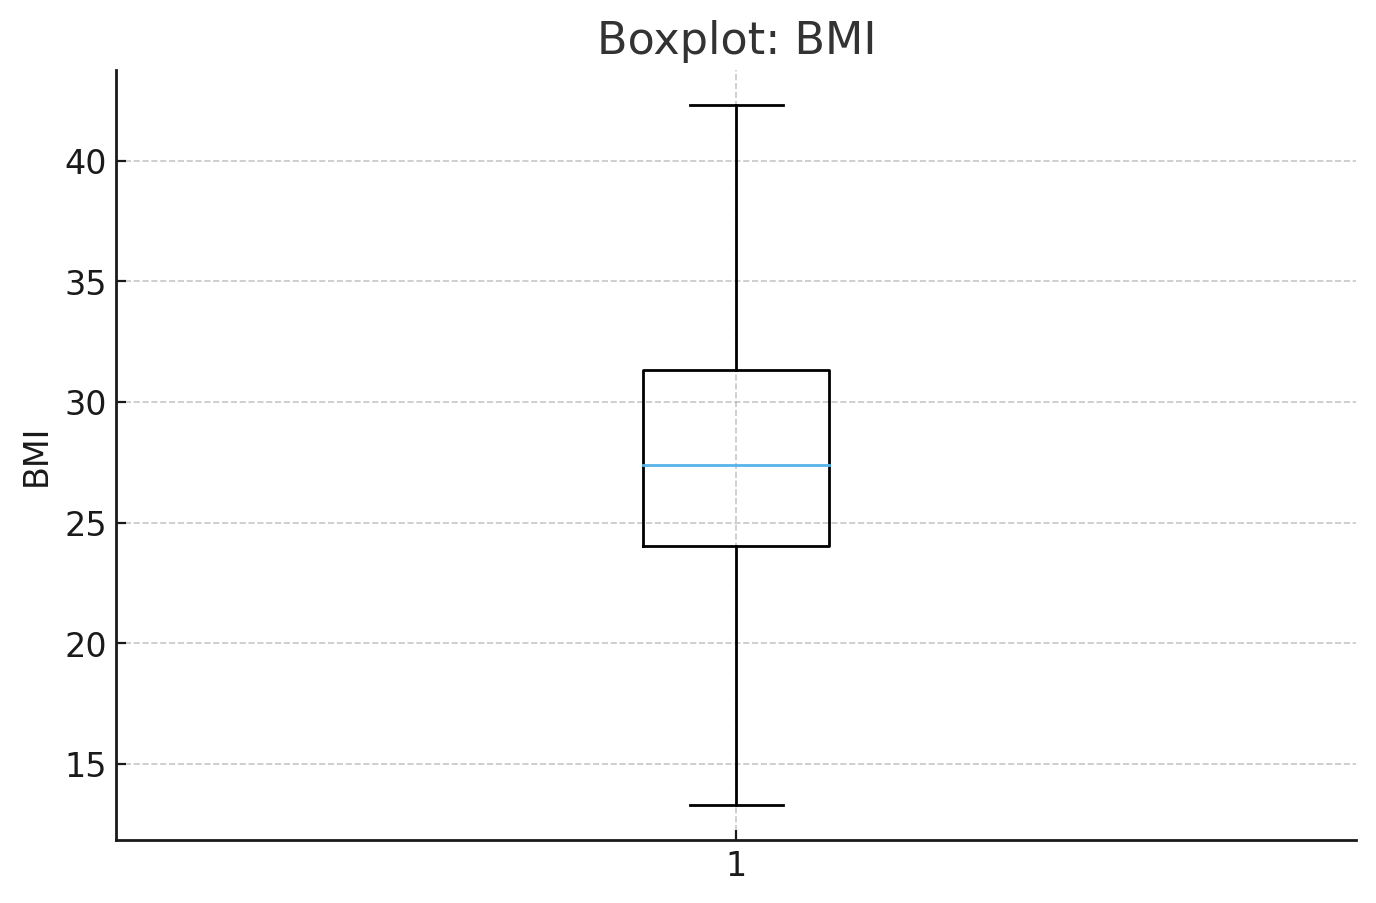

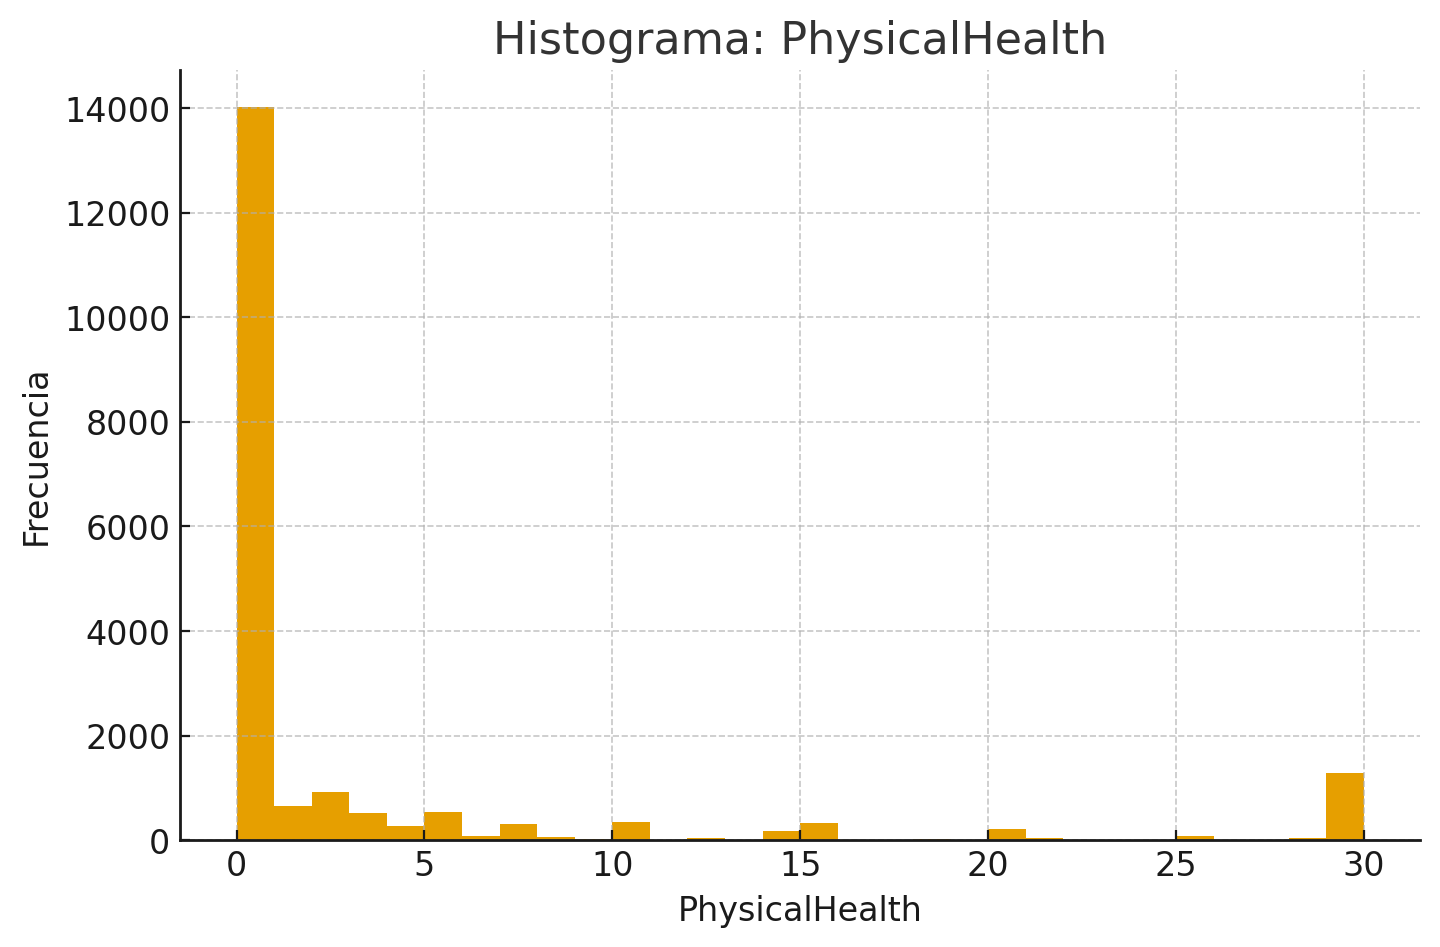

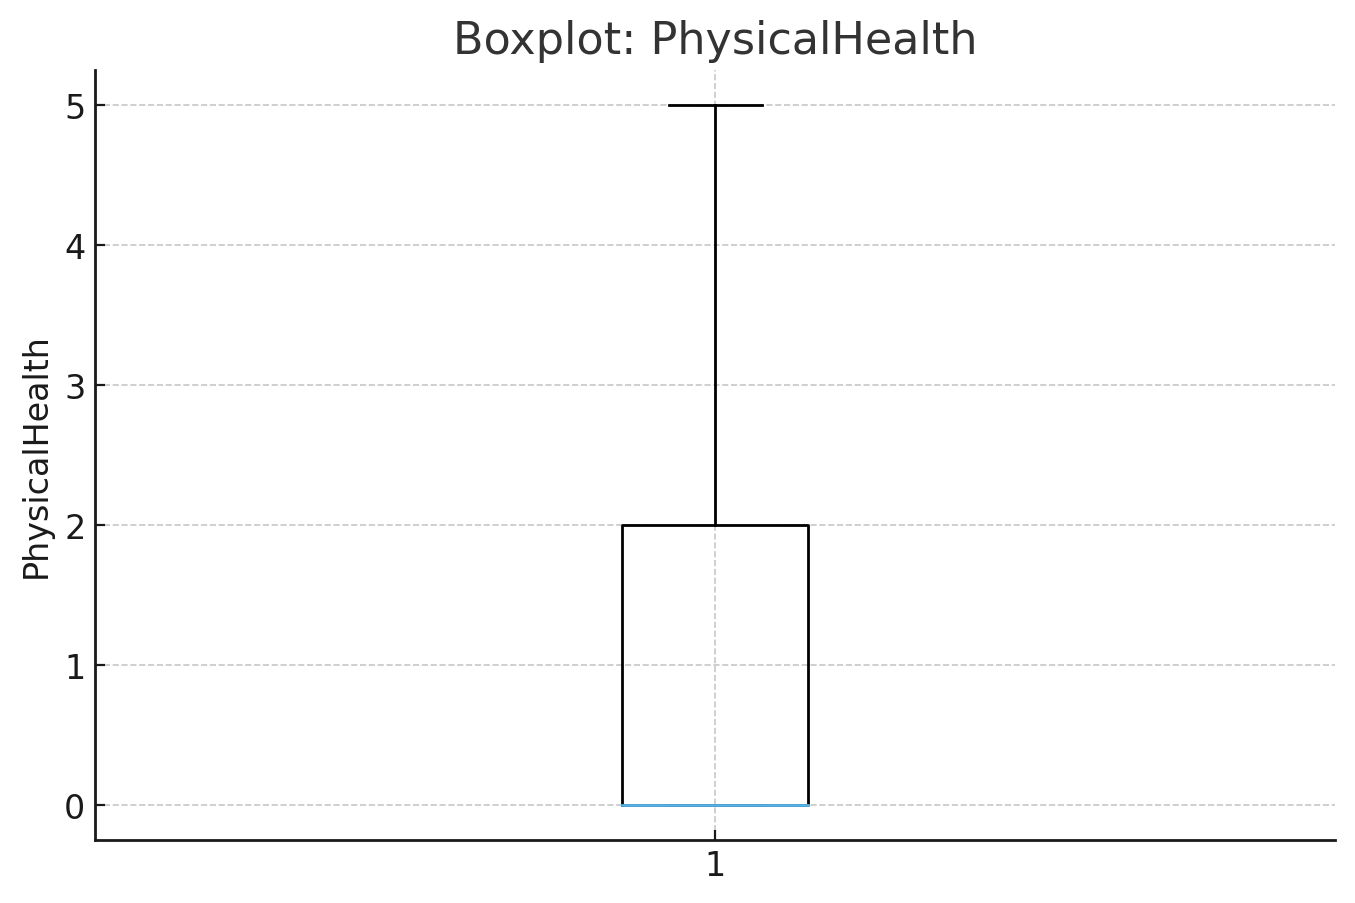

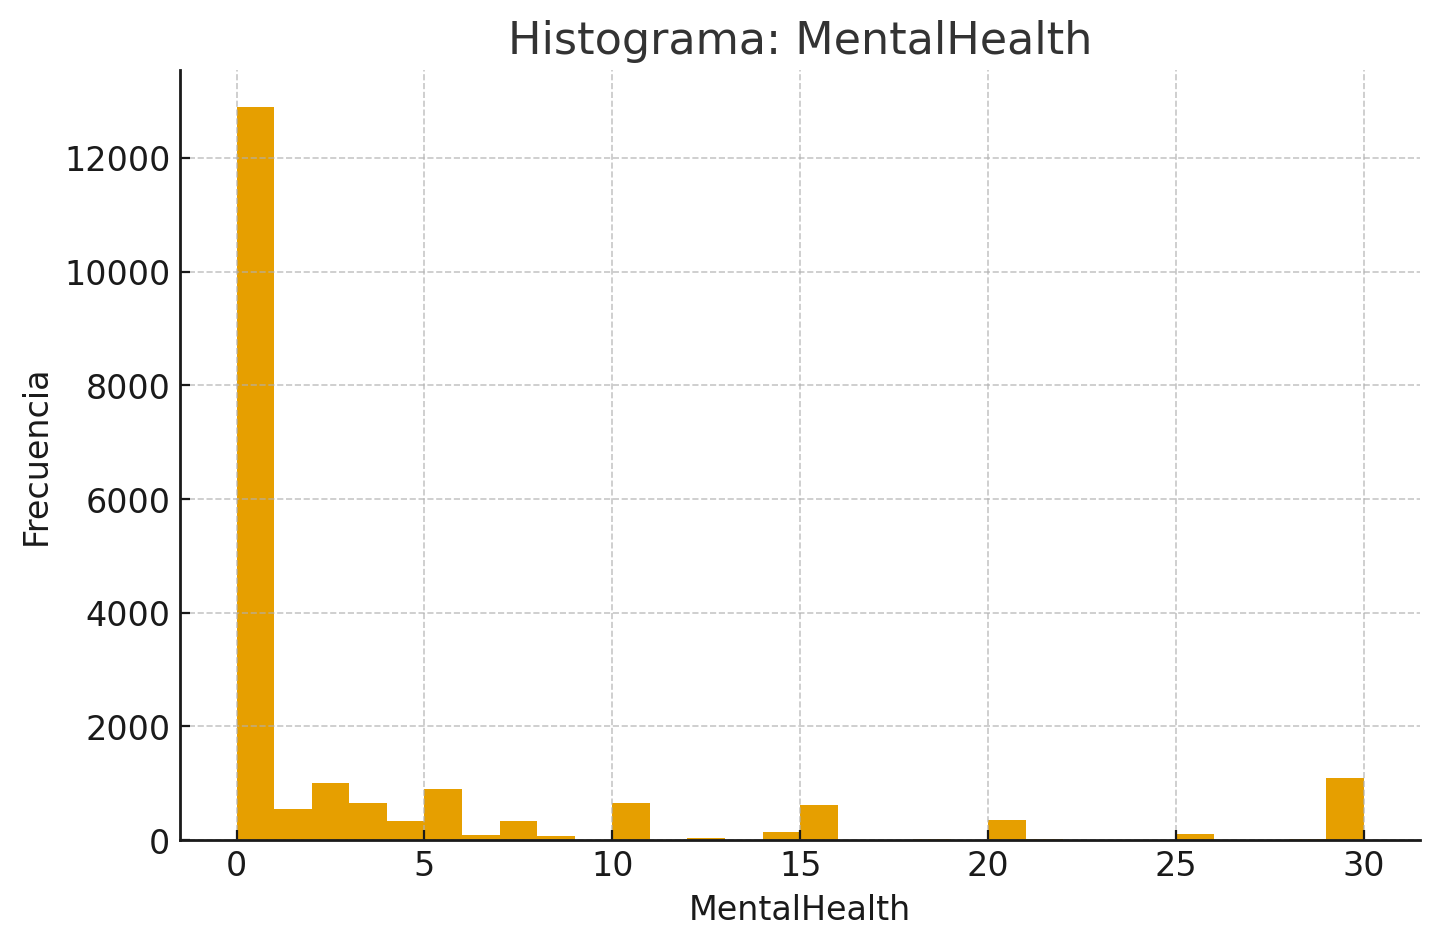

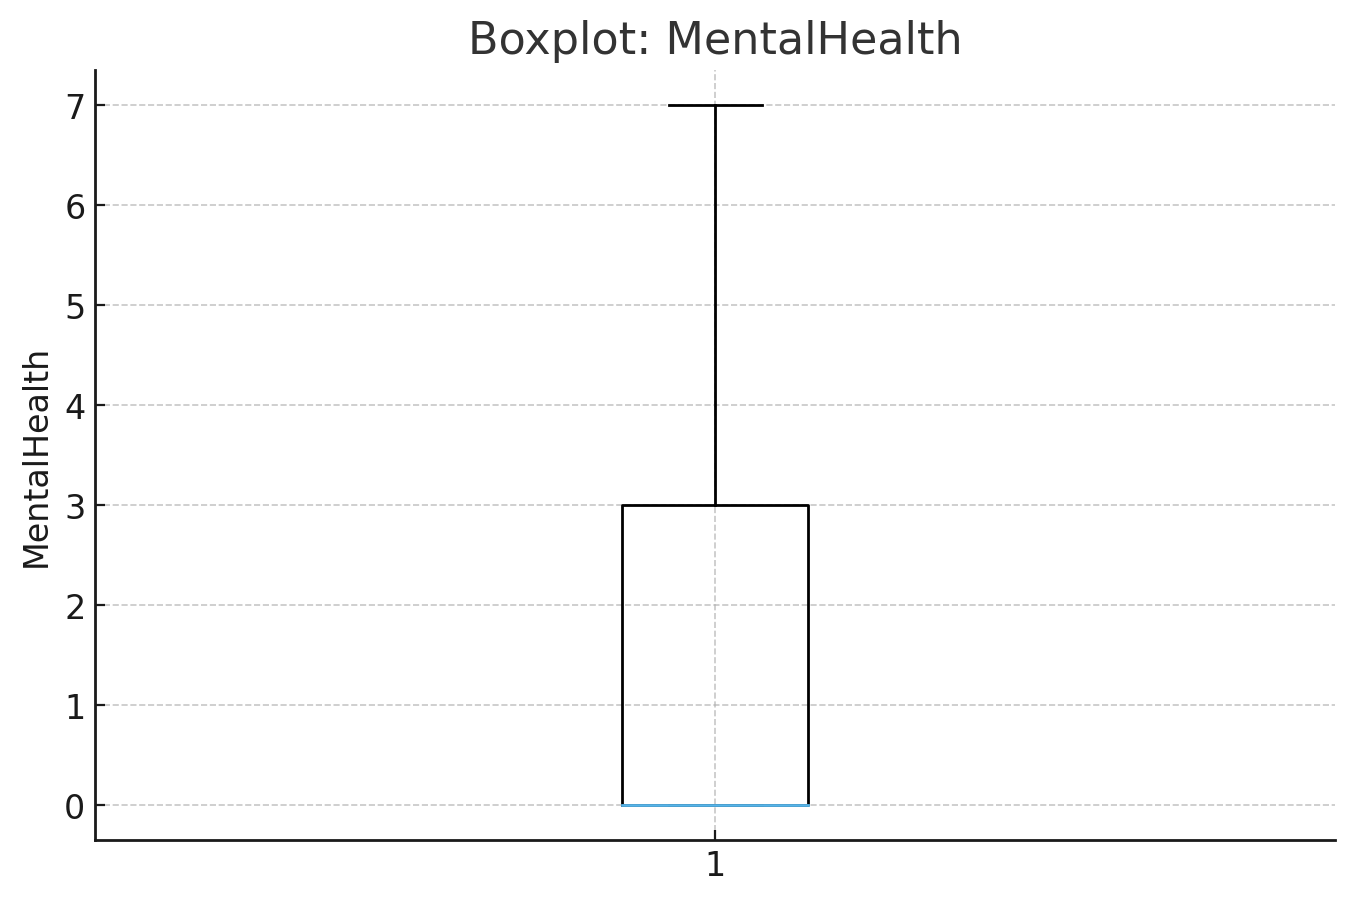

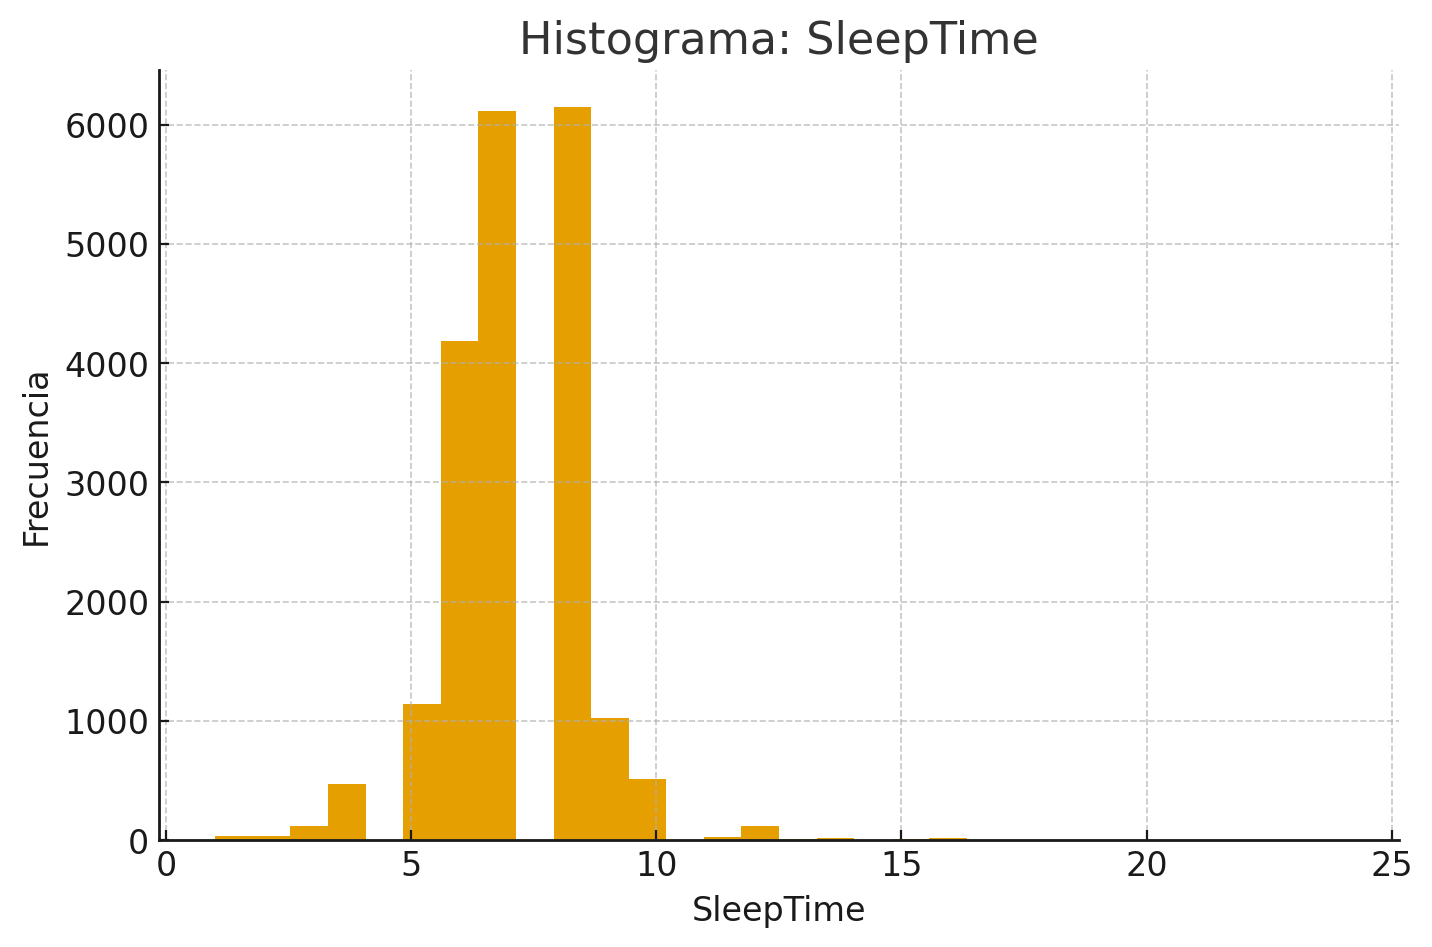

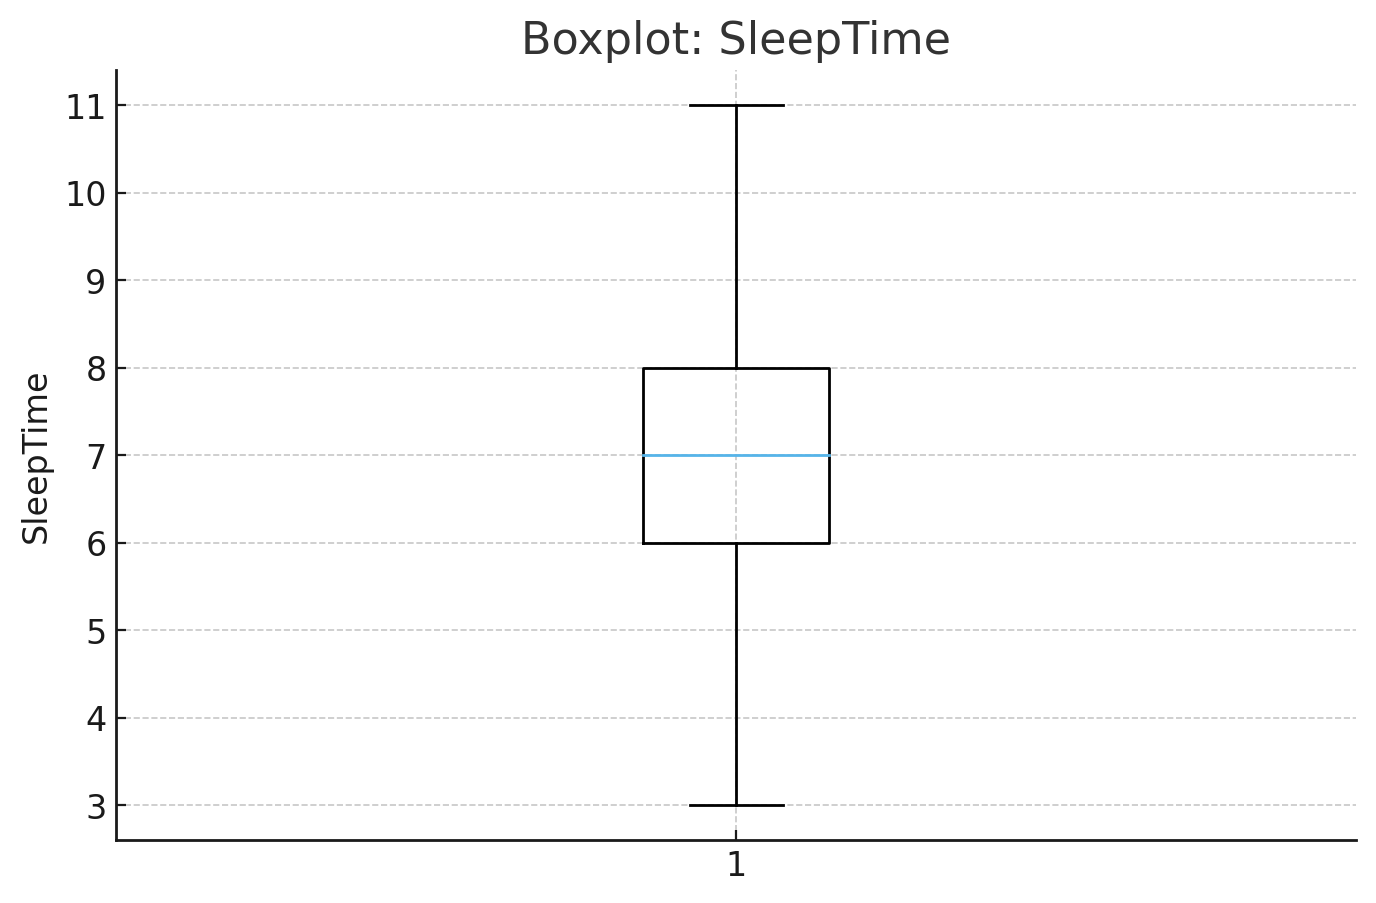

In [5]:

sample = df.sample(n=20000, random_state=42) if len(df)>50000 else df.copy()
for col in num_cols[:6]:
    plt.figure(); plt.hist(sample[col].dropna(), bins=30); plt.title(f'Histograma: {col}'); plt.xlabel(col); plt.ylabel('Frecuencia'); plt.show()
    plt.figure(); plt.boxplot(sample[col].dropna(), vert=True, showfliers=False); plt.title(f'Boxplot: {col}'); plt.ylabel(col); plt.show()


## Univariado — Categóricas

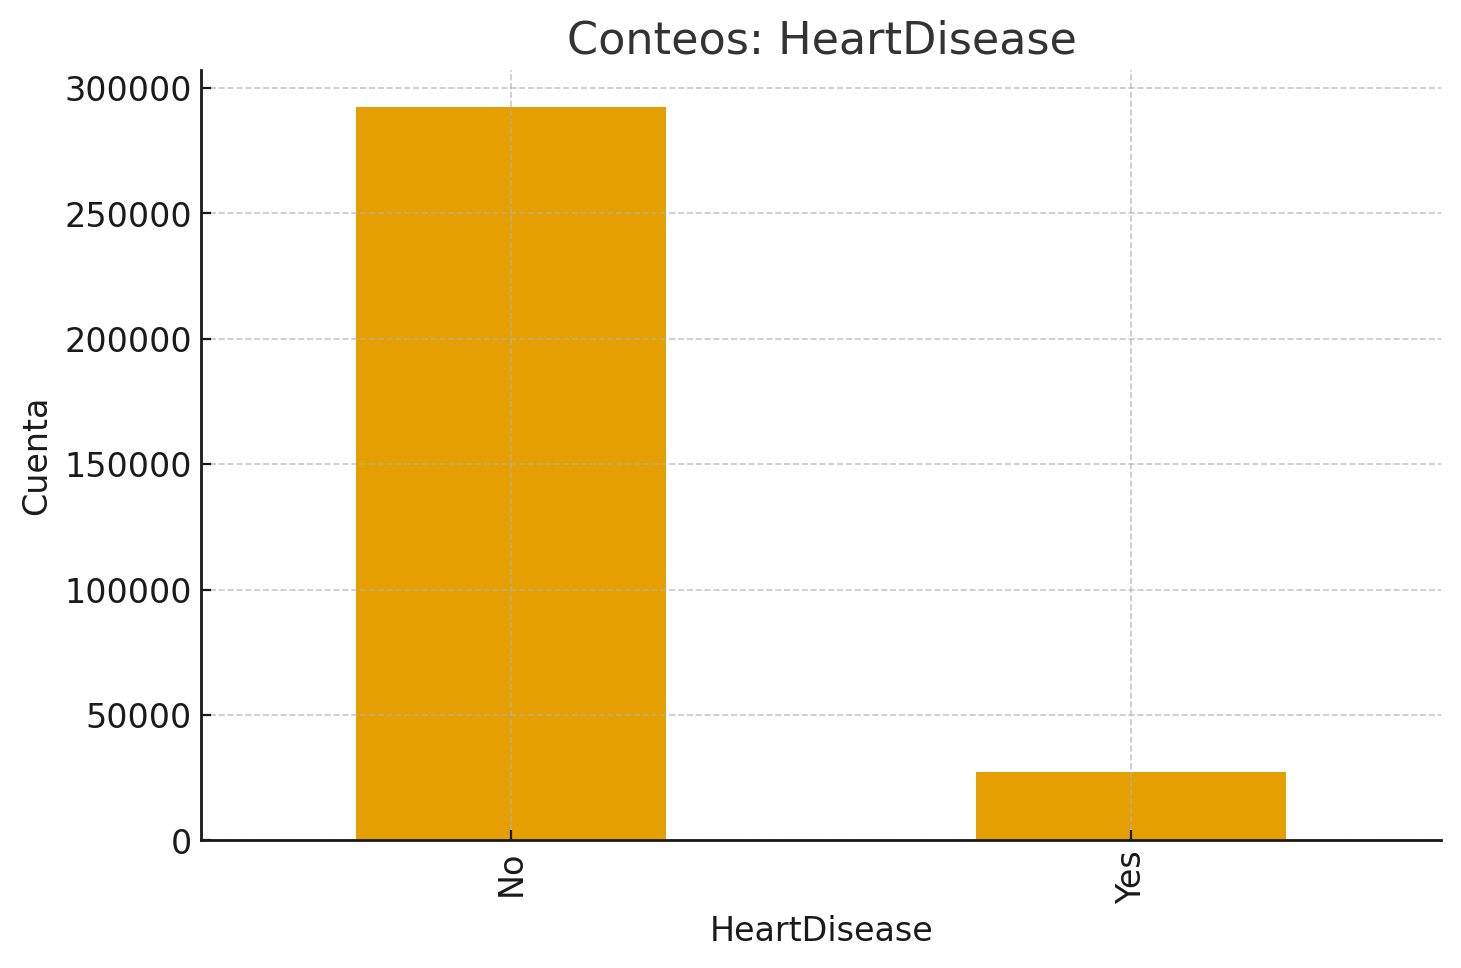

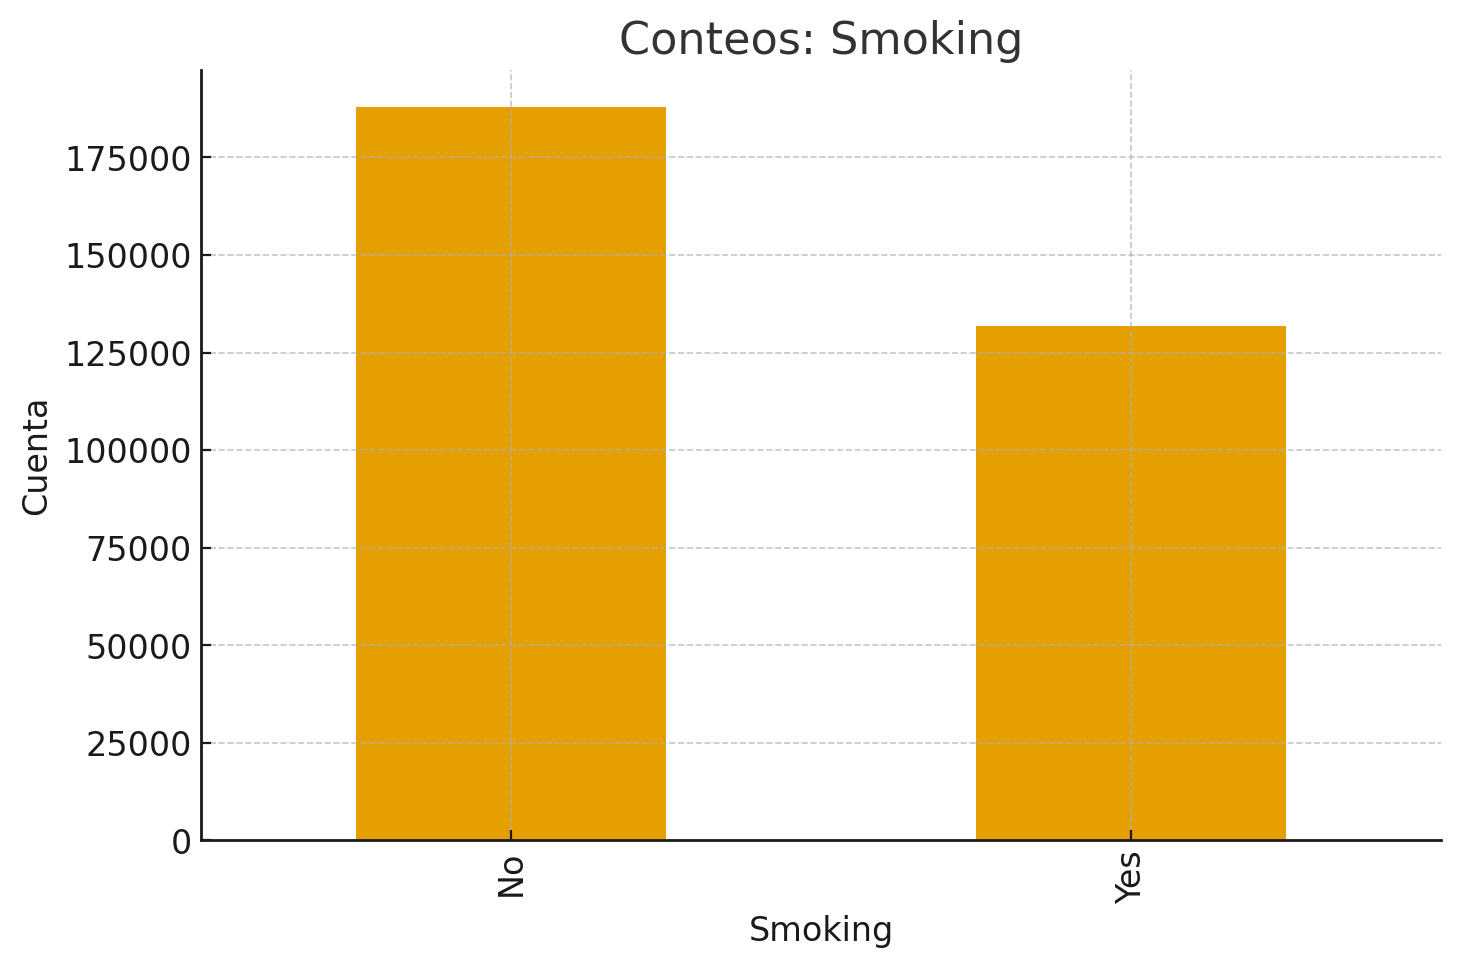

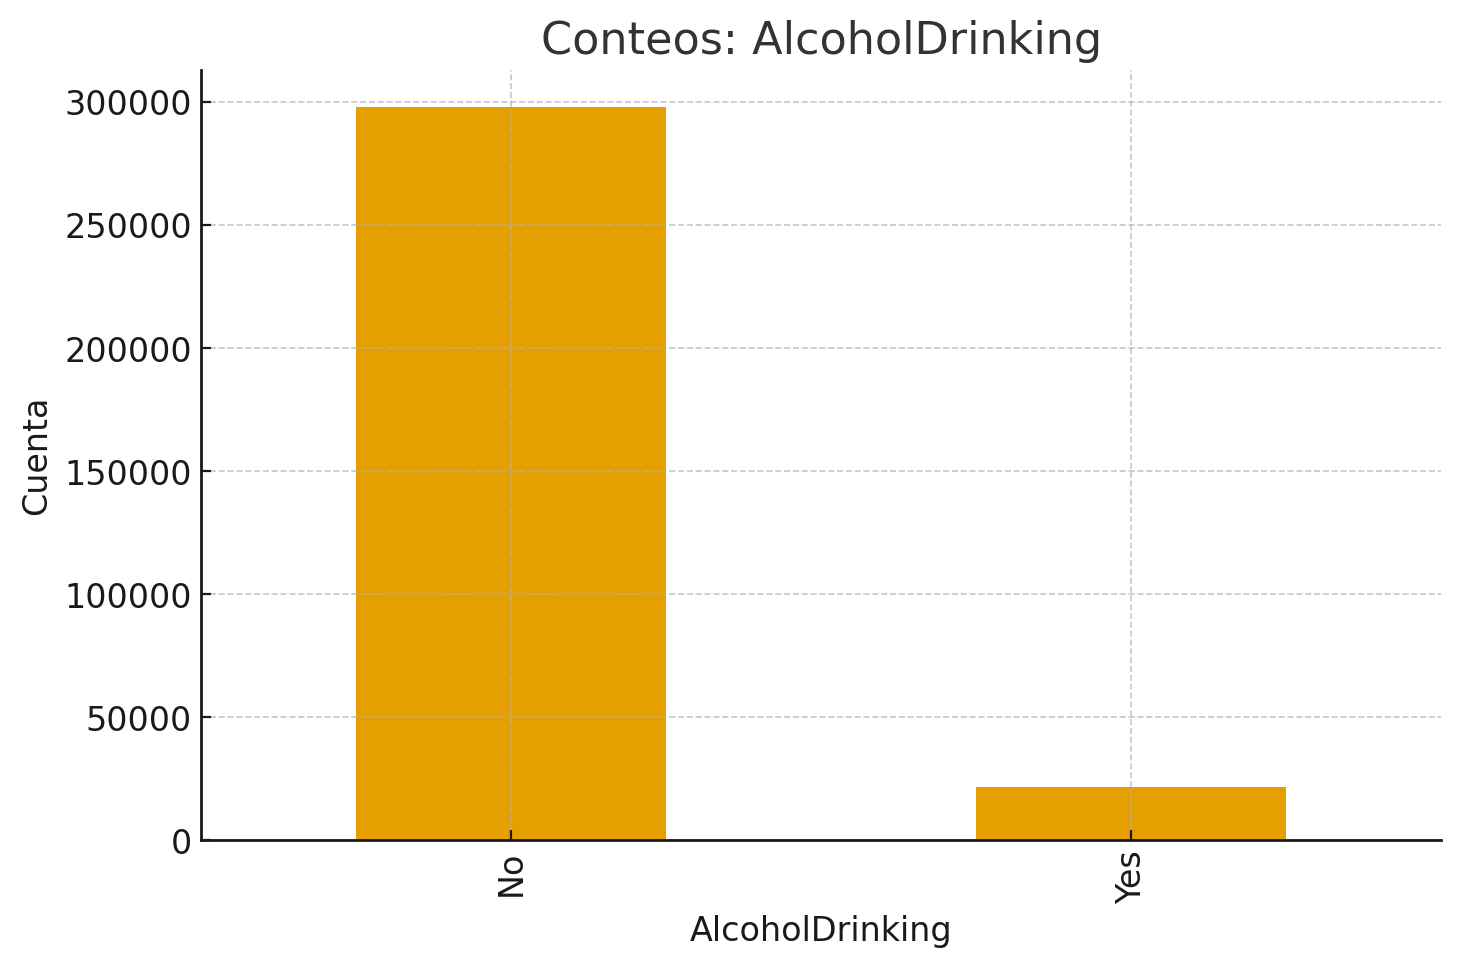

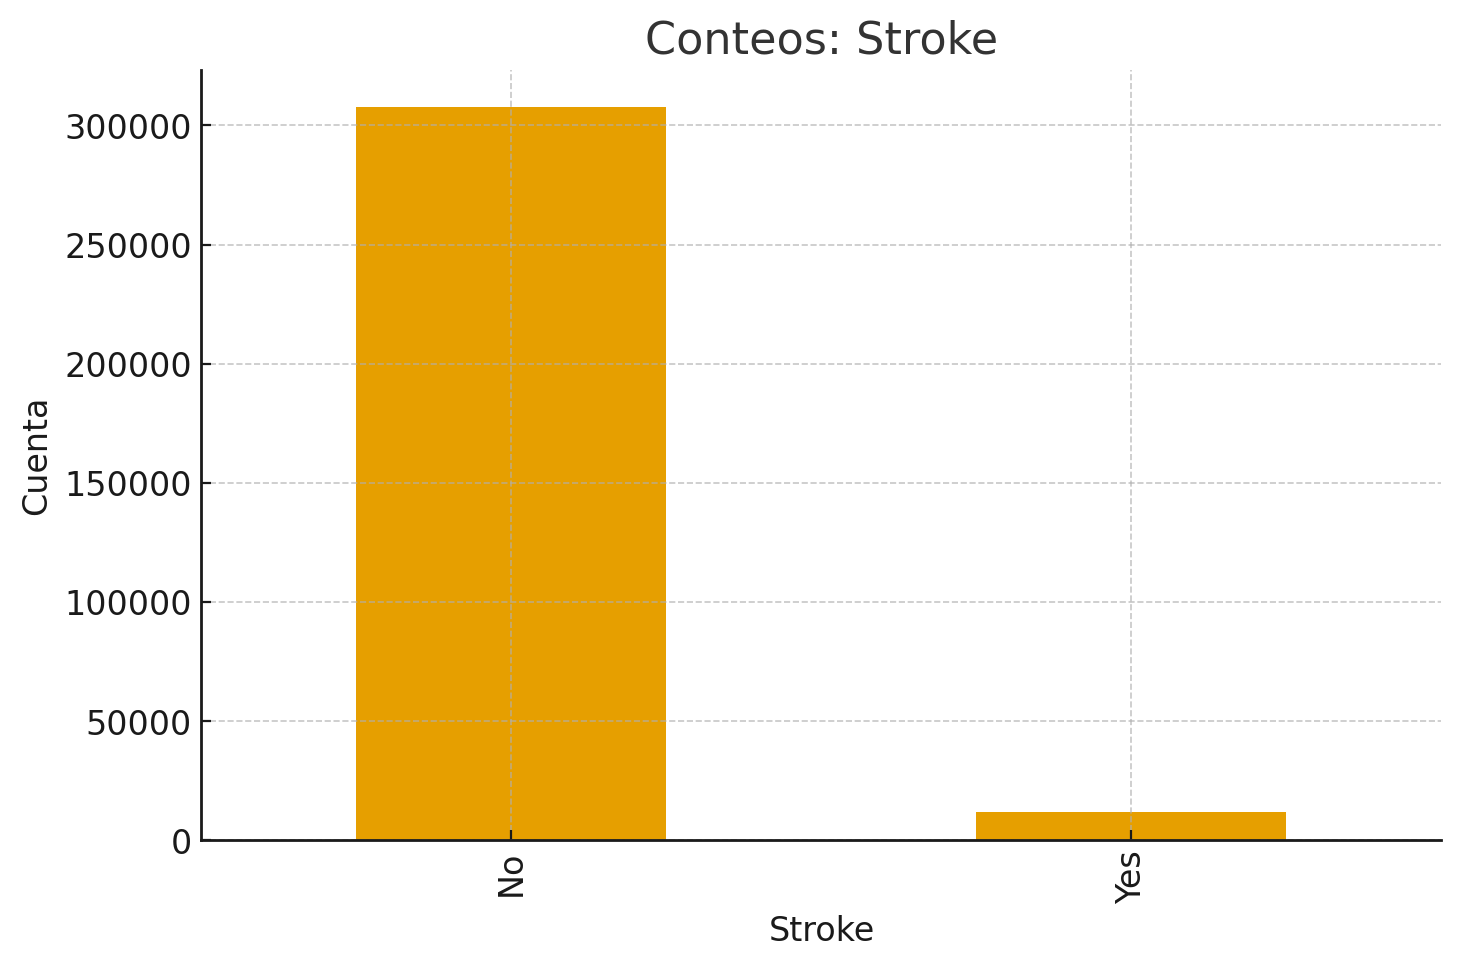

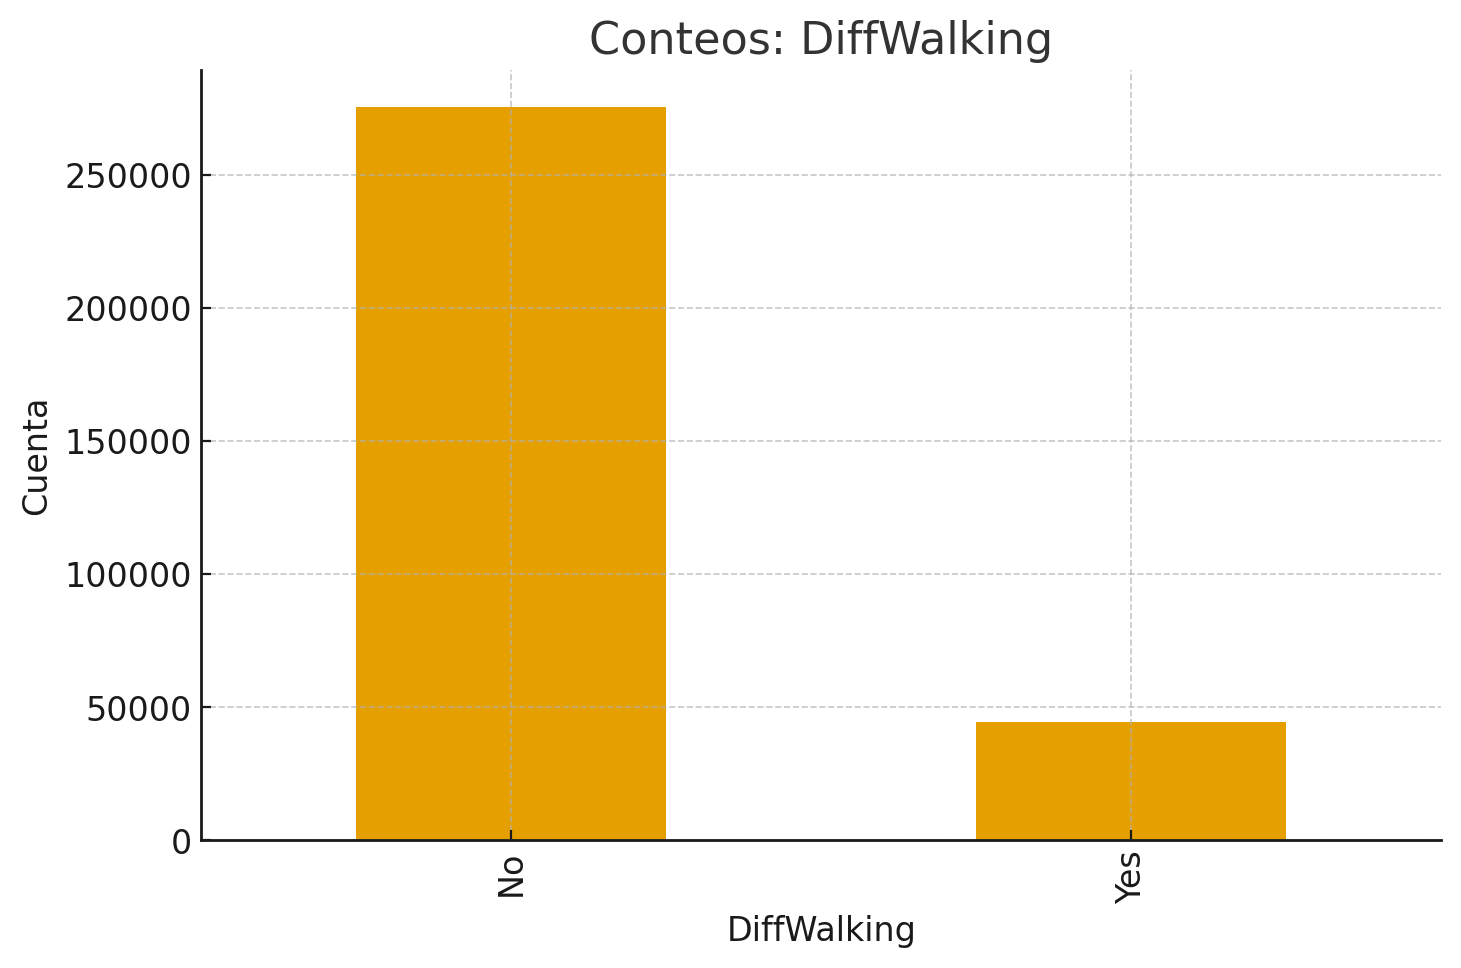

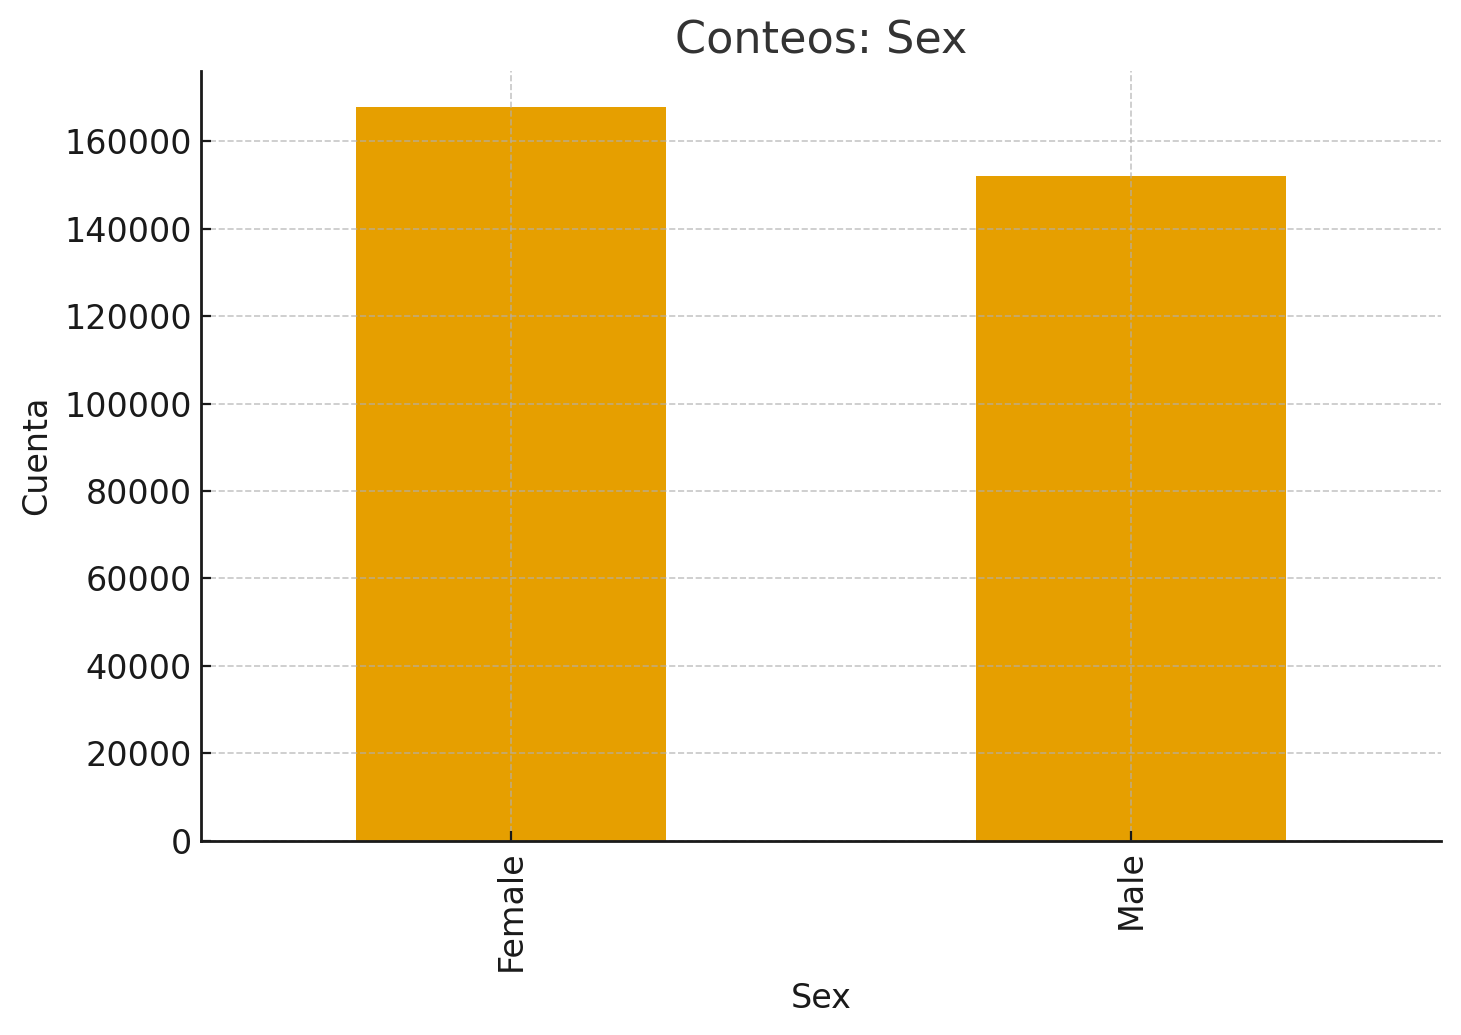

In [6]:

for col in cat_cols[:6]:
    counts = df[col].astype(str).value_counts(dropna=False).head(20)
    plt.figure(); counts.plot(kind='bar'); plt.title(f'Conteos: {col}'); plt.xlabel(col); plt.ylabel('Cuenta'); plt.show()


## Bivariado

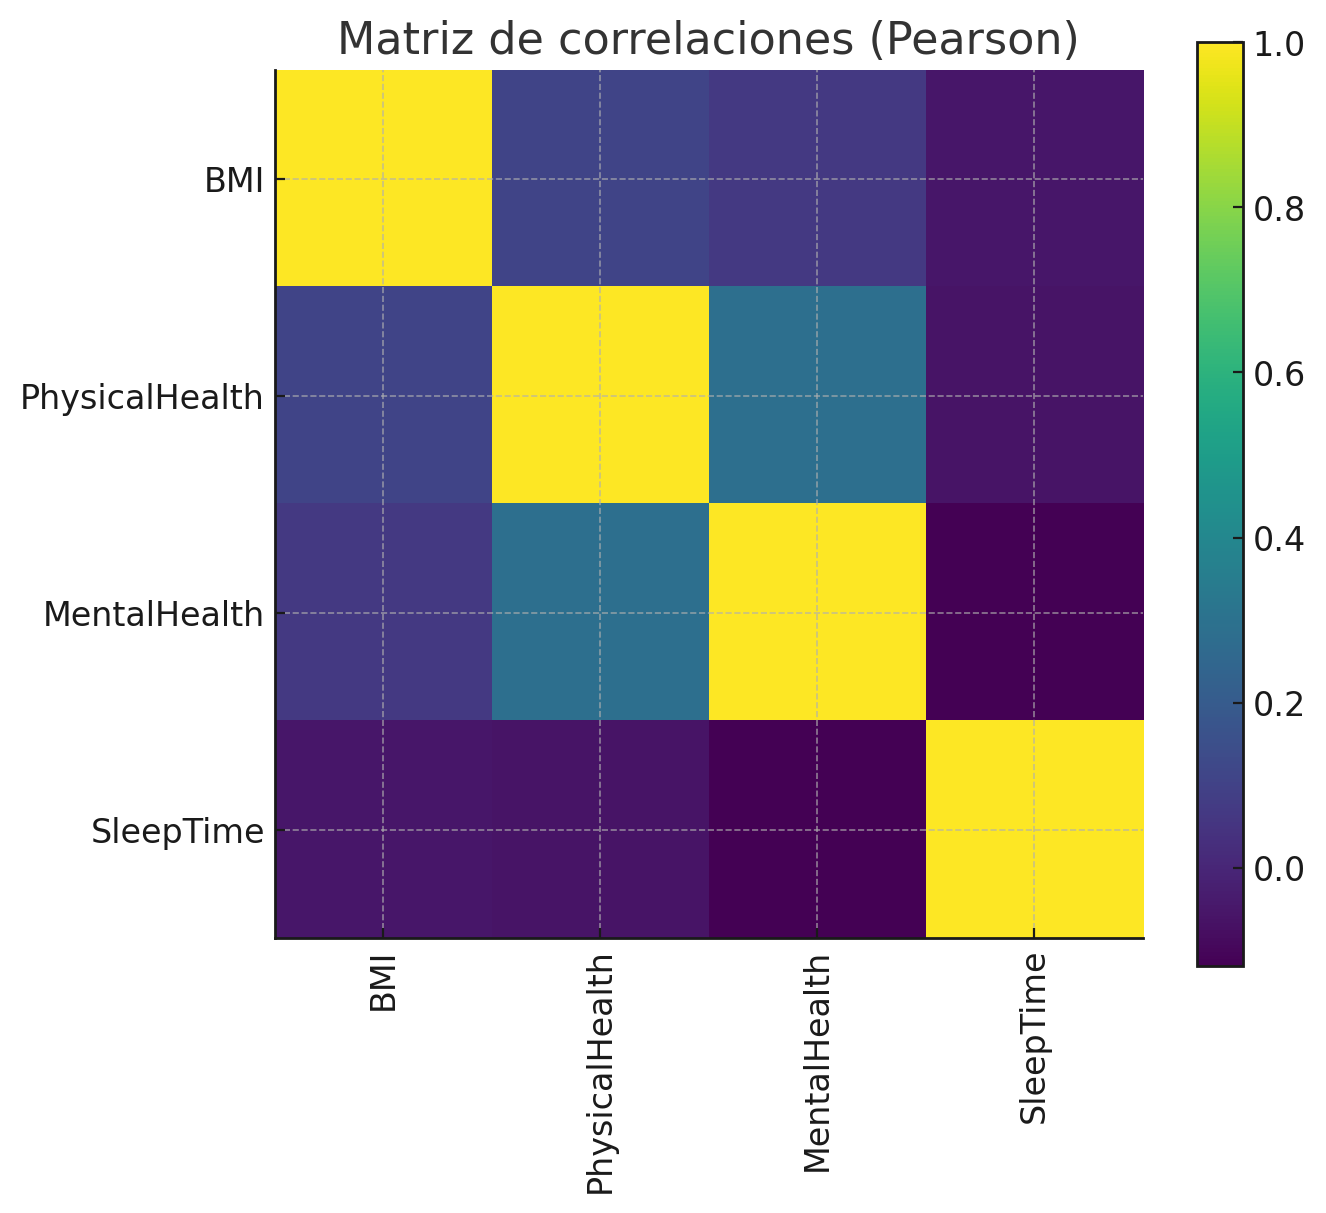

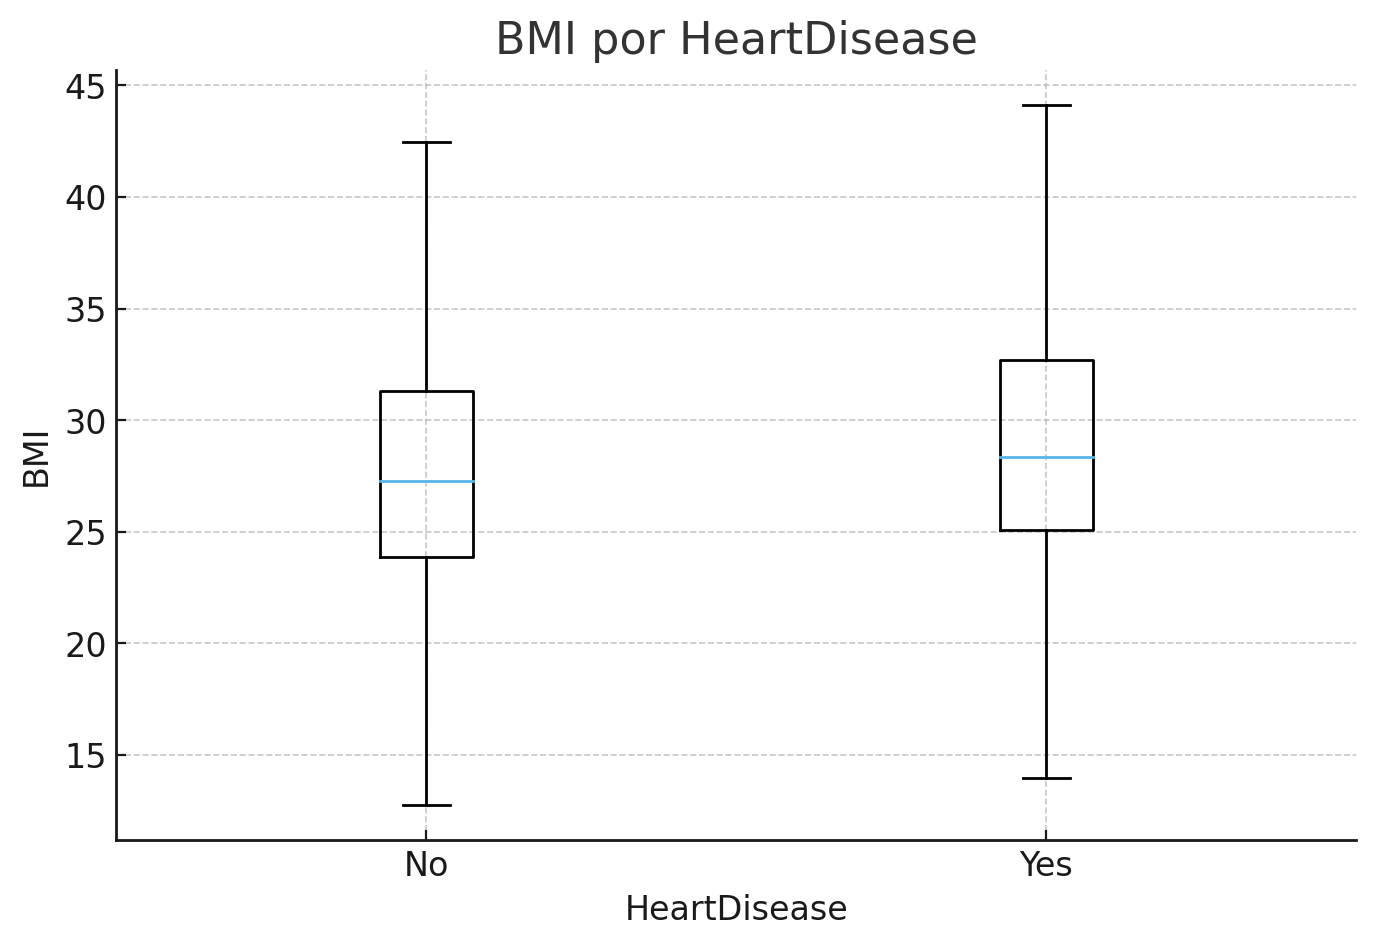

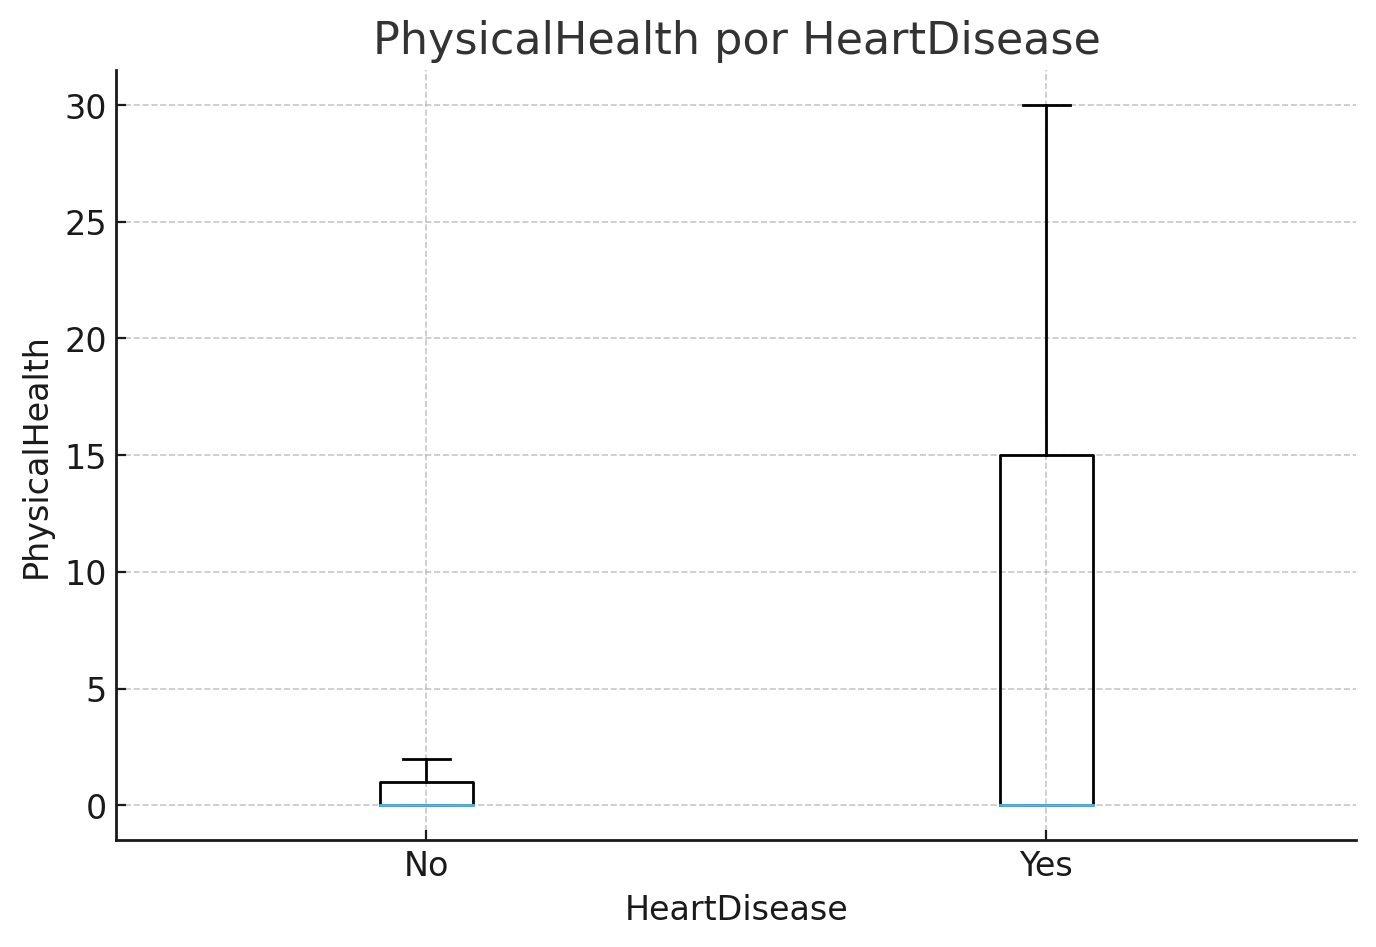

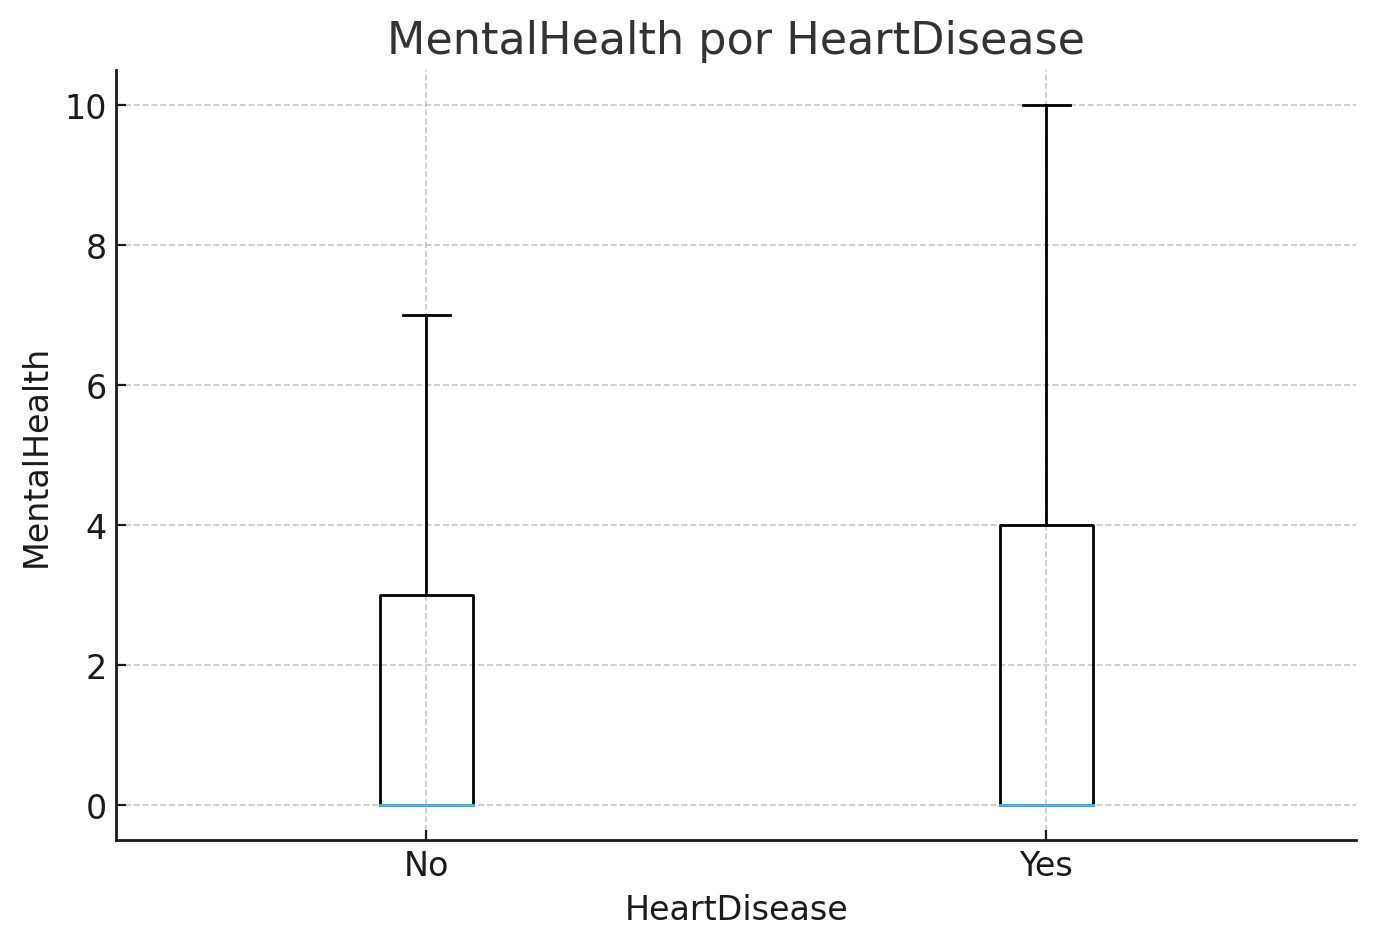

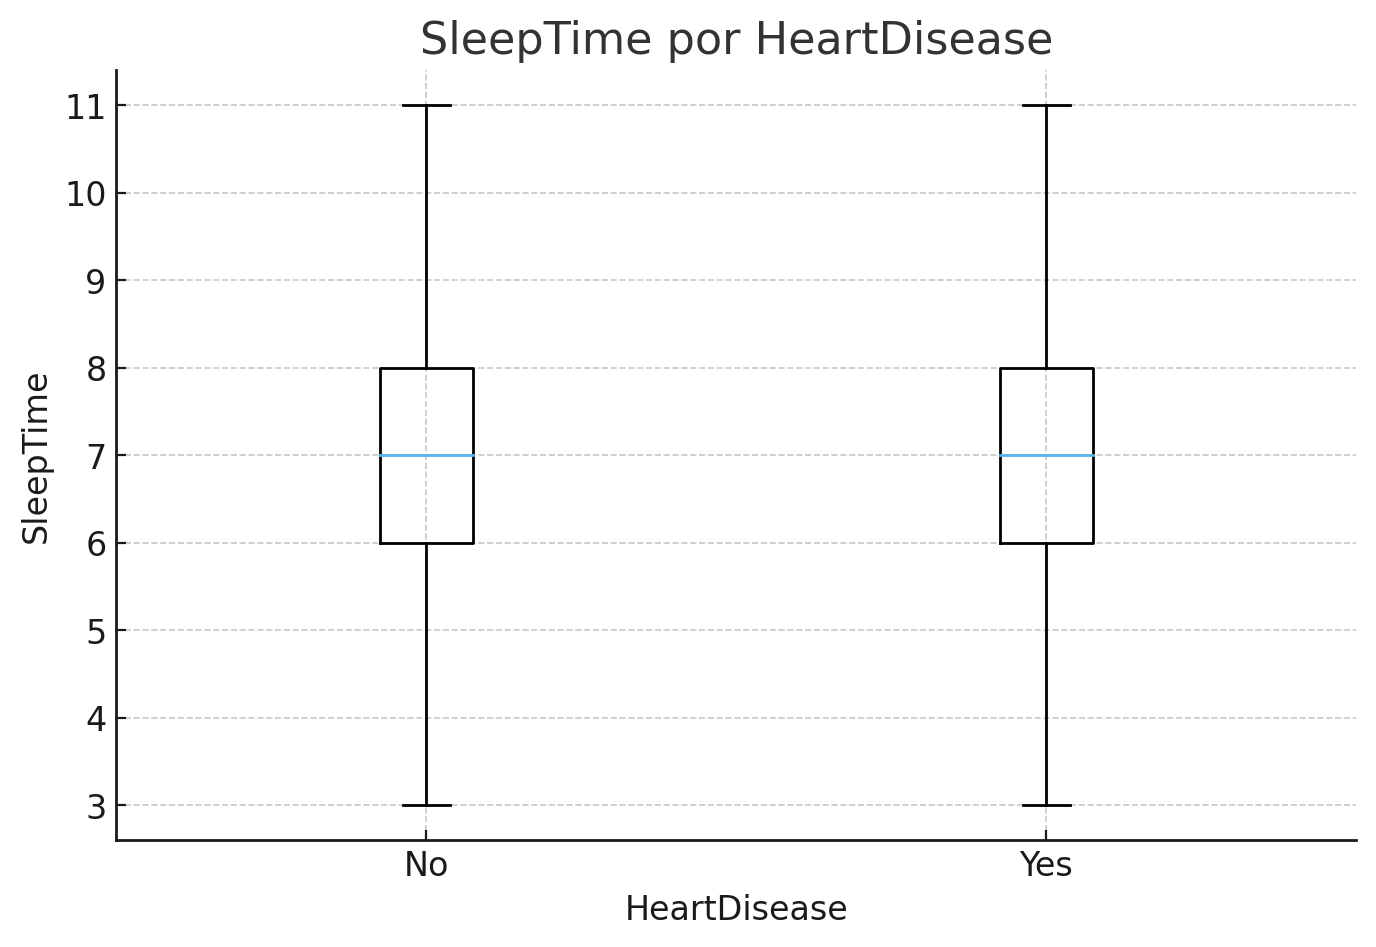

Chi2 HeartDisease ~ Smoking: chi2=3713.0, p=0
Chi2 HeartDisease ~ AlcoholDrinking: chi2=328.6, p=1.89e-73


Chi2 HeartDisease ~ Stroke: chi2=12386.5, p=0
Chi2 HeartDisease ~ DiffWalking: chi2=12951.2, p=0


In [7]:

num_subset = num_cols[:10]
if len(num_subset) >= 2:
    corr = df[num_subset].corr(method='pearson')
    plt.figure(figsize=(7,6)); plt.imshow(corr.values, interpolation='nearest'); plt.xticks(range(len(num_subset)), num_subset, rotation=90); plt.yticks(range(len(num_subset)), num_subset); plt.title('Matriz de correlaciones (Pearson)'); plt.colorbar(); plt.show()

if target is not None and target in df.columns and len(num_cols)>0:
    for col in num_cols[:4]:
        plt.figure(); 
        cats = df[target].astype(str).value_counts().index.tolist()
        data = [df.loc[df[target].astype(str)==c, col].dropna() for c in cats]
        plt.boxplot(data, labels=cats, showfliers=False); plt.title(f'{col} por {target}'); plt.xlabel(target); plt.ylabel(col); plt.show()

from itertools import combinations
pairs = list(combinations(cat_cols[:5], 2))
for (c1, c2) in pairs[:4]:
    tab = pd.crosstab(df[c1].astype(str), df[c2].astype(str))
    if tab.shape[0] > 1 and tab.shape[1] > 1:
        chi2, p, dof, exp = chi2_contingency(tab)
        print(f'Chi2 {c1} ~ {c2}: chi2={chi2:.1f}, p={p:.3g}')


## Multivariado

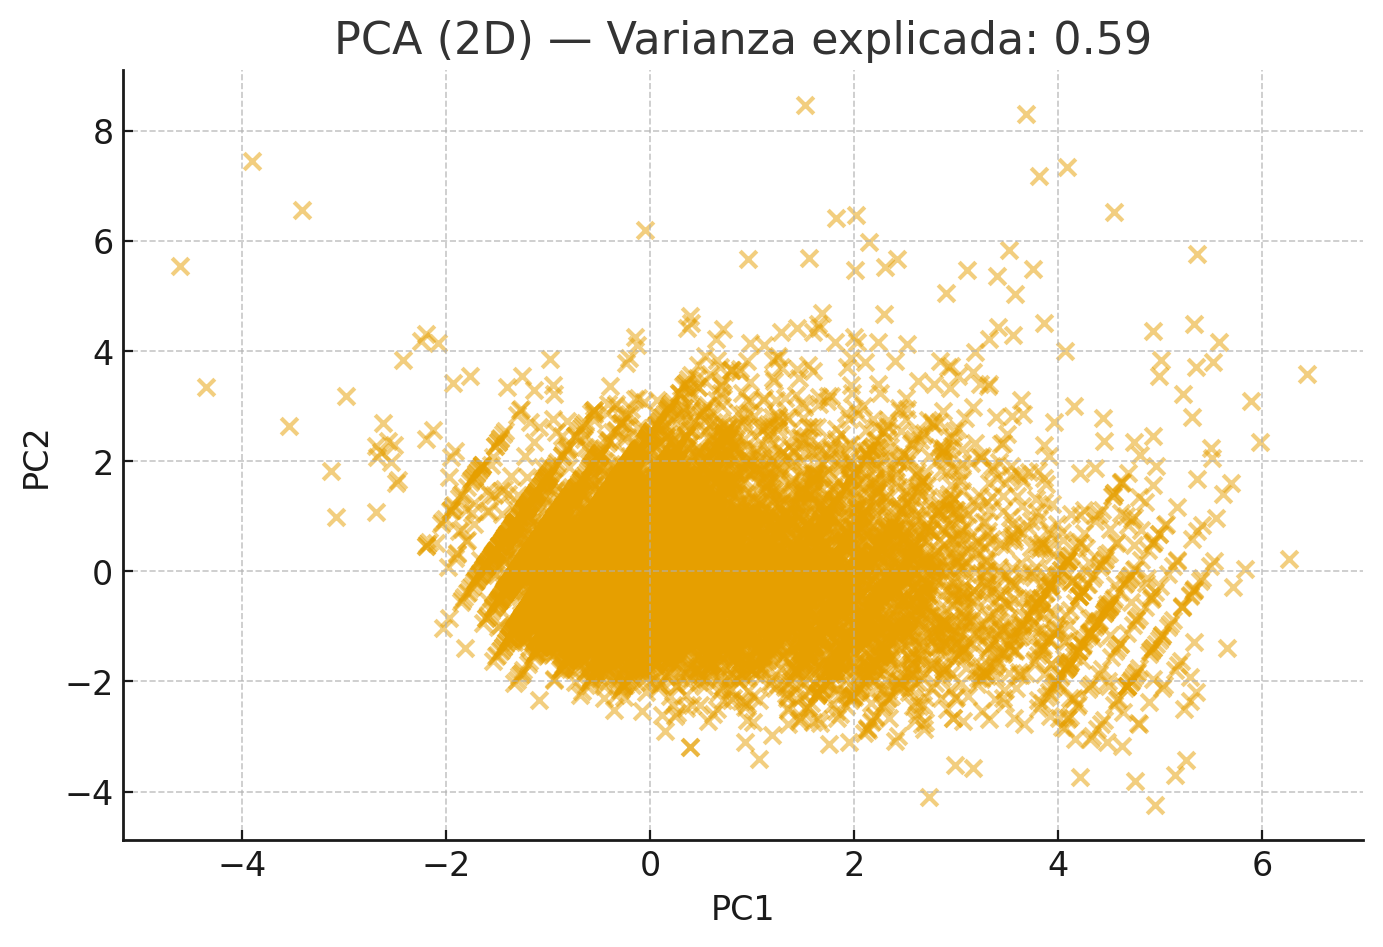

In [8]:

nums = df[num_cols].copy()
if len(df)>50000: nums = nums.sample(n=20000, random_state=42)
if nums.shape[1] >= 2:
    imp = SimpleImputer(strategy='median'); scl = StandardScaler()
    Xs = scl.fit_transform(imp.fit_transform(nums))
    pca = PCA(n_components=2, random_state=42); comps = pca.fit_transform(Xs)
    plt.figure(); plt.scatter(comps[:,0], comps[:,1], alpha=0.5); plt.title(f'PCA (2D) — Varianza explicada: {pca.explained_variance_ratio_.sum():.2f}'); plt.xlabel('PC1'); plt.ylabel('PC2'); plt.show()
else:
    print('No hay suficientes numéricas para PCA.')


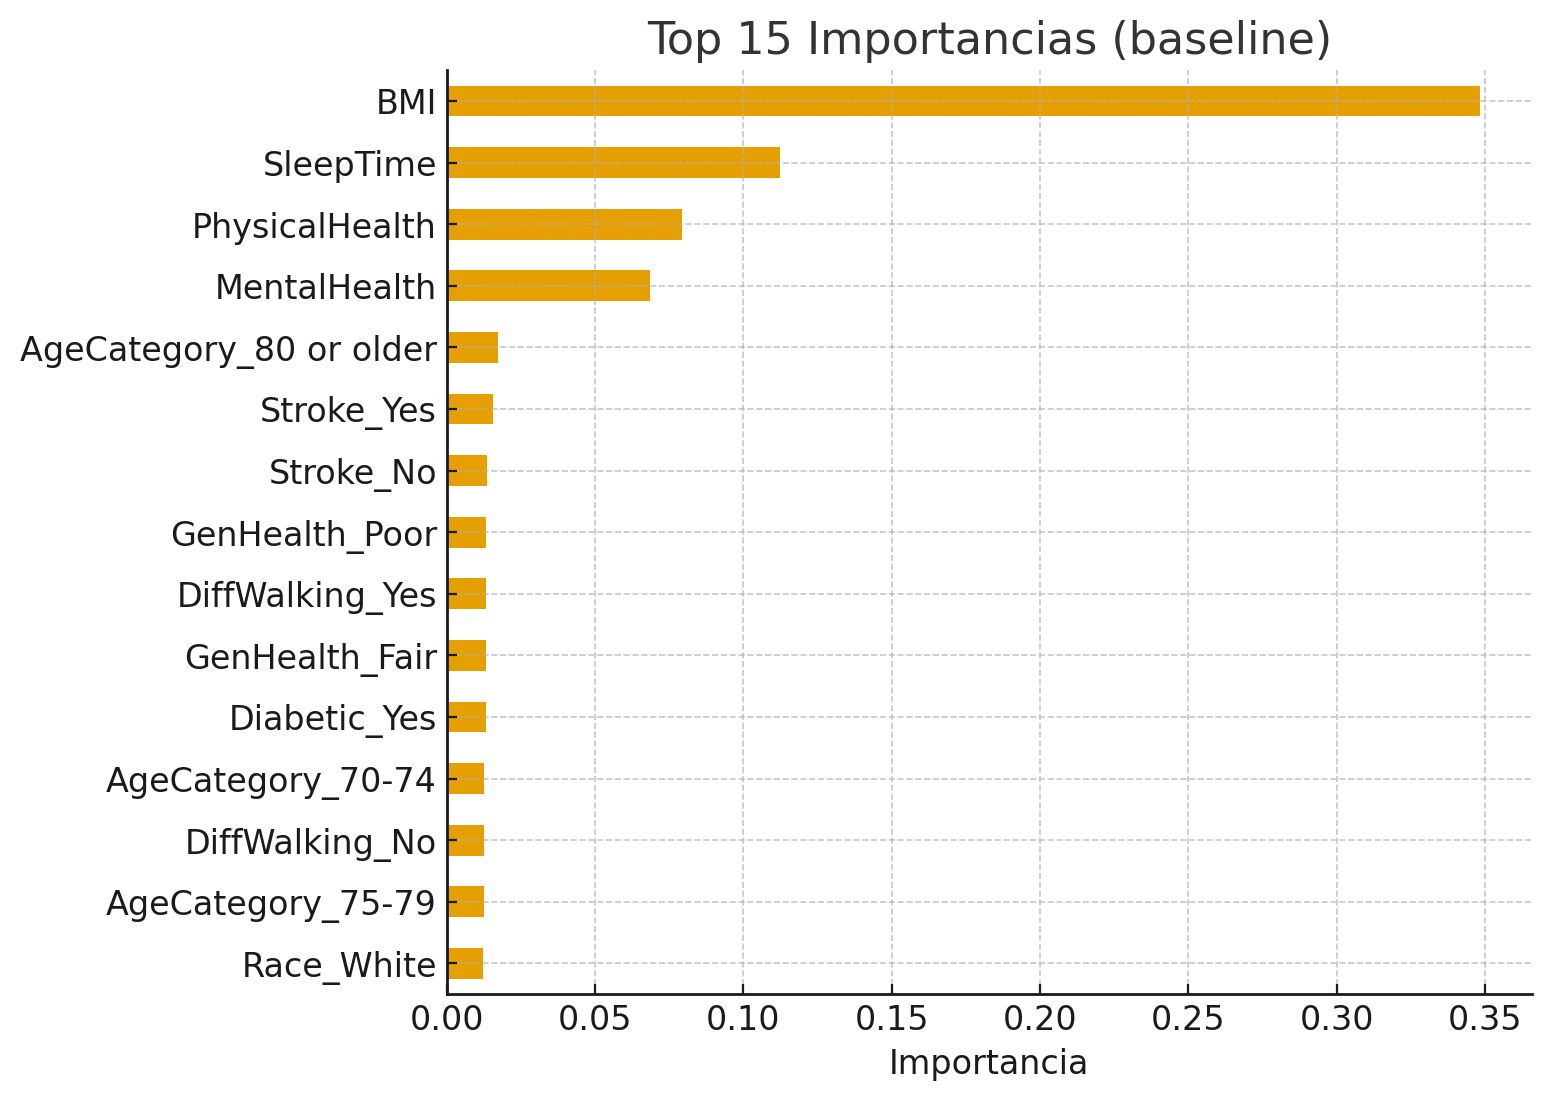

In [9]:

if target is not None and target in df.columns:
    y = df[target]; X = df.drop(columns=[target])
    X_num = X.select_dtypes(include=[np.number]); X_cat = X.drop(columns=X_num.columns).astype('category')
    X_cat = pd.get_dummies(X_cat, dummy_na=True, drop_first=False)
    X_all = pd.concat([X_num, X_cat], axis=1)
    X_all = X_all.fillna(X_all.median(numeric_only=True))

    if y.nunique() <= 20:
        model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    else:
        model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)

    model.fit(X_all, y)
    importances = pd.Series(model.feature_importances_, index=X_all.columns).sort_values(ascending=False).head(15)
    plt.figure(figsize=(7,6)); importances.iloc[::-1].plot(kind='barh'); plt.title('Top 15 Importancias (baseline)'); plt.xlabel('Importancia'); plt.show()
else:
    print('No se detectó variable objetivo para importancias.')
